In [14]:
from os.path import join
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

import data_utils
import viz_utils
import model_utils

wd = join("..", "data")


# load and format datasets summary csv
datasets = pd.read_csv(join(wd, 'csvs', 'current_datasets.csv'))
datasets = datasets[datasets['to_process'] != 'X']
for timecol in ['start_date', 'end_date', 'landfall_time', 'nearest_timepoint', 'acquisition_time']:
    datasets[timecol] = pd.to_datetime(datasets[timecol])

# Temporal satellite acquisition statistics

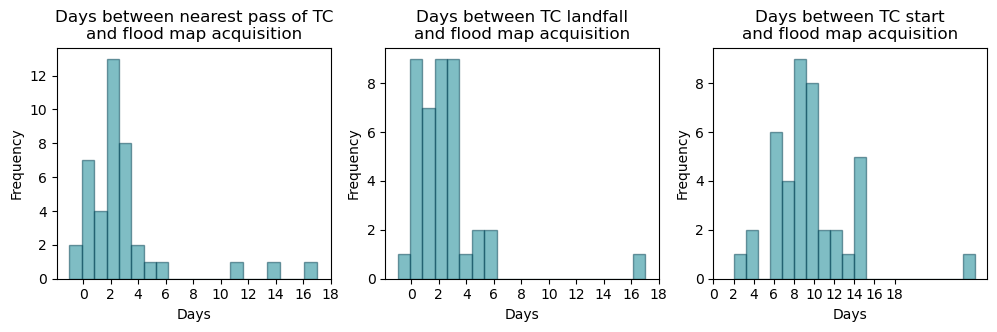

In [41]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

ax = axs[0]
timedelta = (datasets['acquisition_time'] - datasets['nearest_timepoint'])
timedelta.astype('timedelta64[D]').plot.hist(ax=ax, bins=20, alpha=0.5, edgecolor='#003E51', color='#007D8A')
ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18])
ax.set_xlabel('Days')
ax.set_title('Days between nearest pass of TC\nand flood map acquisition');

ax = axs[1]
timedelta = (datasets['acquisition_time'] - datasets['landfall_time'])
timedelta.astype('timedelta64[D]').plot.hist(ax=ax, bins=20, alpha=0.5, edgecolor='#003E51', color='#007D8A')
ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18])
ax.set_xlabel('Days')
ax.set_title('Days between TC landfall\nand flood map acquisition');

ax = axs[2]
timedelta = (datasets['acquisition_time'] - datasets['start_date'])
timedelta.astype('timedelta64[D]').plot.hist(ax=ax, bins=20, alpha=0.5, edgecolor='#003E51', color='#007D8A')
ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18])
ax.set_xlabel('Days')
ax.set_title('Days between TC start\nand flood map acquisition');


# Histogram of ocean basins

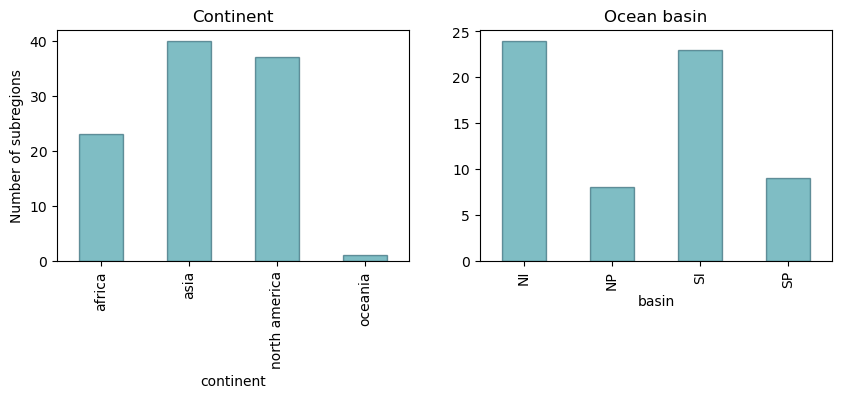

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

datasets.groupby('continent')['nsubregions'].sum().plot(kind='bar', alpha=0.5, edgecolor='#003E51', color='#007D8A', ax=ax[0])
datasets.groupby('basin')['nsubregions'].sum().plot(kind='bar', alpha=0.5, edgecolor='#003E51', color='#007D8A', ax=ax[1])

ax[0].set_title('Continent')
ax[1].set_title('Ocean basin')

ax[0].set_ylabel('Number of subregions');

## Geographic locations plot

In [4]:
gdf = model_utils.load_spatial_data(wd)
gdf_centroid = gdf.set_geometry(gdf.centroid)

gdf_events = gdf.dissolve(by='event')
gdf_events_centroid = gdf_events.set_geometry(gdf_events.centroid)

/var/folders/7w/k72v6f5x25gblsqmh6bxd3j40000gn/T/ipykernel_8051/3941047350.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_centroid = gdf.set_geometry(gdf.centroid)
/var/folders/7w/k72v6f5x25gblsqmh6bxd3j40000gn/T/ipykernel_8051/3941047350.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_events_centroid = gdf_events.set_geometry(gdf_events.centroid)


In [5]:
gdf_events_centroid = gdf_events_centroid.reset_index()

In [6]:
def get_event_feature(string, datasets=datasets, feature='source'):
    
    strings = string.split('_')[:-1]
    event = strings[0]
    region = '_'.join(strings[1:])
    
    idx = pd.IndexSlice
    datasets = datasets.set_index(['event', 'region'])
    feature = datasets.loc[idx[event, region]][feature]
    
    return feature

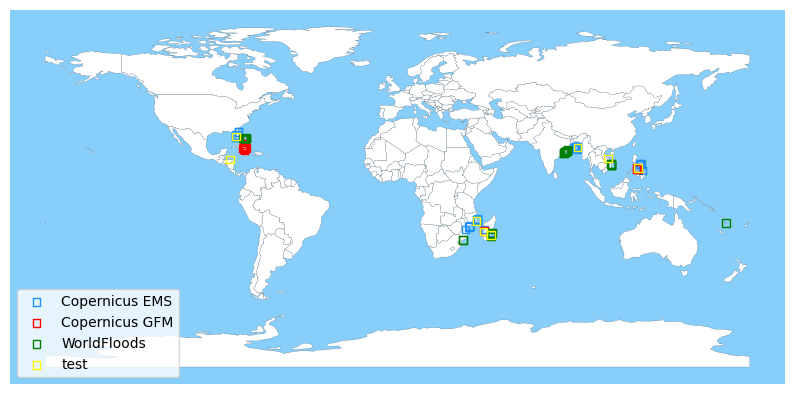

In [54]:
import geoplot

test_events = ['gombe_mossuril_1', 'emnati_madagascar_3_0', 'batsirai_menabe_0',
               'noul_vietnam_0', 'roanu_satkania_0', 'megi_westernvisayas_0',
               'iota_loweraguanbasin_0', 'irma_tampasouth_0']

gdf_events_centroid['source'] =  gdf_events_centroid['event'].apply(lambda x: get_event_feature(x))
mask = gdf_events_centroid['event'].isin(test_events)
gdf_train = gdf_events_centroid[~mask]
gdf_test = gdf_events_centroid[mask]


world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black', linewidth=0.1, figsize=(10, 10),
                facecolor='blue') # geoplot.polyplot(world)


markers = ['s', 's', 's']  # , 'p', 'P', '*', 'D', 'X']
features = [*pd.unique(gdf_events_centroid['source'])]
colours = ['dodgerblue', 'red', 'green']  # , 'purple', 'orange', 'yellow', 'grey', 'cyan']

for i, feature in enumerate(features):
    to_plot = gdf_train[gdf_train['source']==feature]
    to_plot.plot(facecolor="none", edgecolor=colours[i], ax=ax, marker=markers[i], label=feature, alpha=1, markersize=30)

gdf_test.plot(facecolor="none", edgecolor='yellow', ax=ax, marker='s', label='test', markersize=30)
plt.legend(loc='lower left')

ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_facecolor("lightskyblue")

plt.savefig(join(wd, 'images', 'geographic_locations.png'), bbox_inches='tight', dpi=500)